In [8]:
%matplotlib inline

In [9]:
###############################################################
# H2 ECONOMY BOX MODEL                                        #
# (c) Paul Griffiths, John Pyle, Nicola Warwick, James Keeble #
# University of Cambridge, 2020                               #
# Done under contract for BEIS                                #
###############################################################

#
# initial imports - consult requirements.txt for versions of
# modules under which the figures were produced
# using Python3
#
import pylab as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as style
import seaborn as sns
import datetime
localtime = datetime.datetime.now().strftime("%Y_%m_%d")

In [10]:
####################
# plotting options #
####################
mpl.rc('figure', figsize=(10,10),facecolor='white', dpi=300)
mpl.rc('figure.subplot', wspace= 0.4, hspace=0.2)
mpl.rc('figure.subplot', hspace= 0.2)
mpl.rc('axes', grid=1, titlesize=20)
mpl.rc('axes.formatter',limits=(-2,5))
mpl.rc('lines', linewidth=2, color='r')
mpl.rc('font', size=14)
pal = sns.color_palette("Set1")
style.use('seaborn-poster')
sns.set_style('whitegrid')

In [11]:
###########################################################################
# Define two models - based on scientific uncertainty in hydrogen removal #
# Model 1 - constant surface flux term of 59 Tg per year                  #
# Model 1 is called kin_cr                                                #
# Model 2 - Deposition via first order loss                               #
# Model 2 is called kin                                                   #
###########################################################################
def kin(S,y,t):
    temp=288.
    kH2 = 4.27E-13*np.exp(-1240./temp)*((temp/298.)**2.406)
    fracland = 0.05
    kdep = 2e-4/1000*fracland # deposition at 0.2mm s-1 over 1km BLH
    kCH4 = 5e-15
    kCO = 2e-13
    kX = 1.
    yr_in_secs = 360.*24.*3600
    kloss = 1./(2.5*yr_in_secs)
    SH2, SCH4, SCO, SOH = S
    H2, CH4, CO, OH = y
    dH2  = SH2  - kdep*H2 - kH2*OH*H2
    dCH4 = SCH4 - kCH4*OH*CH4
    dCO  = SCO  - kCO*OH*CO + kCH4*OH*CH4
    dOH  = SOH  - kX*OH - kCH4*OH*CH4 - kCO*OH*CO - kH2*OH*H2
    return dH2, dCH4, dCO, dOH

def kin_cr(S,y,t):
    yr_in_secs = 360.*24.*3600
    temp=288.
    kH2 = 4.27E-13*np.exp(-1240./temp)*((temp/298.)**2.406)
    fixedrem = 59.20*1e9/5e18*28.8/2.*2.5e19/yr_in_secs
    kCH4 = 5e-15
    kCO = 2e-13
    kX = 1.
    yr_in_secs = 360.*24.*3600
    kloss = 1./(2.5*yr_in_secs)
    SH2, SCH4, SCO, SOH = S
    H2, CH4, CO, OH = y
    dH2  = SH2  - fixedrem - kH2*OH*H2
    dCH4 = SCH4 - kCH4*OH*CH4
    dCO  = SCO  - kCO*OH*CO + kCH4*OH*CH4
    dOH  = SOH  - kX*OH - kCH4*OH*CH4 - kCO*OH*CO - kH2*OH*H2
    return dH2, dCH4, dCO, dOH

In [12]:
###########################################
# routines to integrate box model forward #
###########################################
def integrate_box(S, initial_concs, fin, starttime, nyrs):
    from functools import partial
    ppbv_to_per_cm3 = 2.5e10
    yr_in_s = 60.*60.*24.*365.
    SH2_in_Tg, SCH4_in_Tg, SCO_in_Tg, SOH_in_cm3_per_sec = S
    # converrt from Tg per year to molecules per cm3 per sec
    SH2 = SH2_in_Tg*1e9/5e18*28.8/2.*2.5e19/yr_in_s
    SCH4 = SCH4_in_Tg*1e9/5e18*28.8/16.*2.5e19/yr_in_s
    SCO = SCO_in_Tg*1e9/5e18*28.8/30.*2.5e19/yr_in_s
    SOH = SOH_in_cm3_per_sec
    Sinit = np.array([SH2, SCH4, SCO, SOH])

    H2i, CH4i, COi, OHi = initial_concs
    yinit  = np.array([H2i*ppbv_to_per_cm3, CH4i*ppbv_to_per_cm3, COi*ppbv_to_per_cm3 , OHi])

    time = np.linspace(start=0.0, stop=nyrs*yr_in_s, num=nyrs*12*30)
    y2 =  odeint(partial(fin,Sinit), yinit,  time)

    times = pd.date_range(start=starttime, periods=nyrs*12*30, freq='D')
    H2 =  pd.Series(data=y2[:,0]/ppbv_to_per_cm3, index=times)
    CH4 = pd.Series(data=y2[:,1]/ppbv_to_per_cm3, index=times)
    CO =  pd.Series(data=y2[:,2]/ppbv_to_per_cm3, index=times)
    OH =  pd.Series(data=y2[:,3], index=times)
    return H2, CH4, CO, OH

In [13]:
init = np.array([0., 0., 0., 0.])

In [14]:
########################################
# INITIAL CONDITIONS  and source terms #
########################################
# Anthropogenic hydrogen sources # 17 Tg per year
Santhro = 17.#Santhro = SBuildings + Stransport + Spower

# Biomass burning H2 sources 15 Tg per year
SBB = 15.

# N2 fixation is 8 Tg
SN2 = 8.

# so total photochemical prod = 36 Tg
SCH4oxid = 18.
SVOCoxid = 18.

# Soceans is 4 Tg
Soceans = 4.

SH2 = Santhro + SBB + SCH4oxid + SVOCoxid + Soceans + SN2 #Tg H2 per year
SCH4 = 520. # Tg per year
SCO = 1370. # Tg per year
SOH = 1.17e6 # molecules per cm3 per sec throughout the tropospher

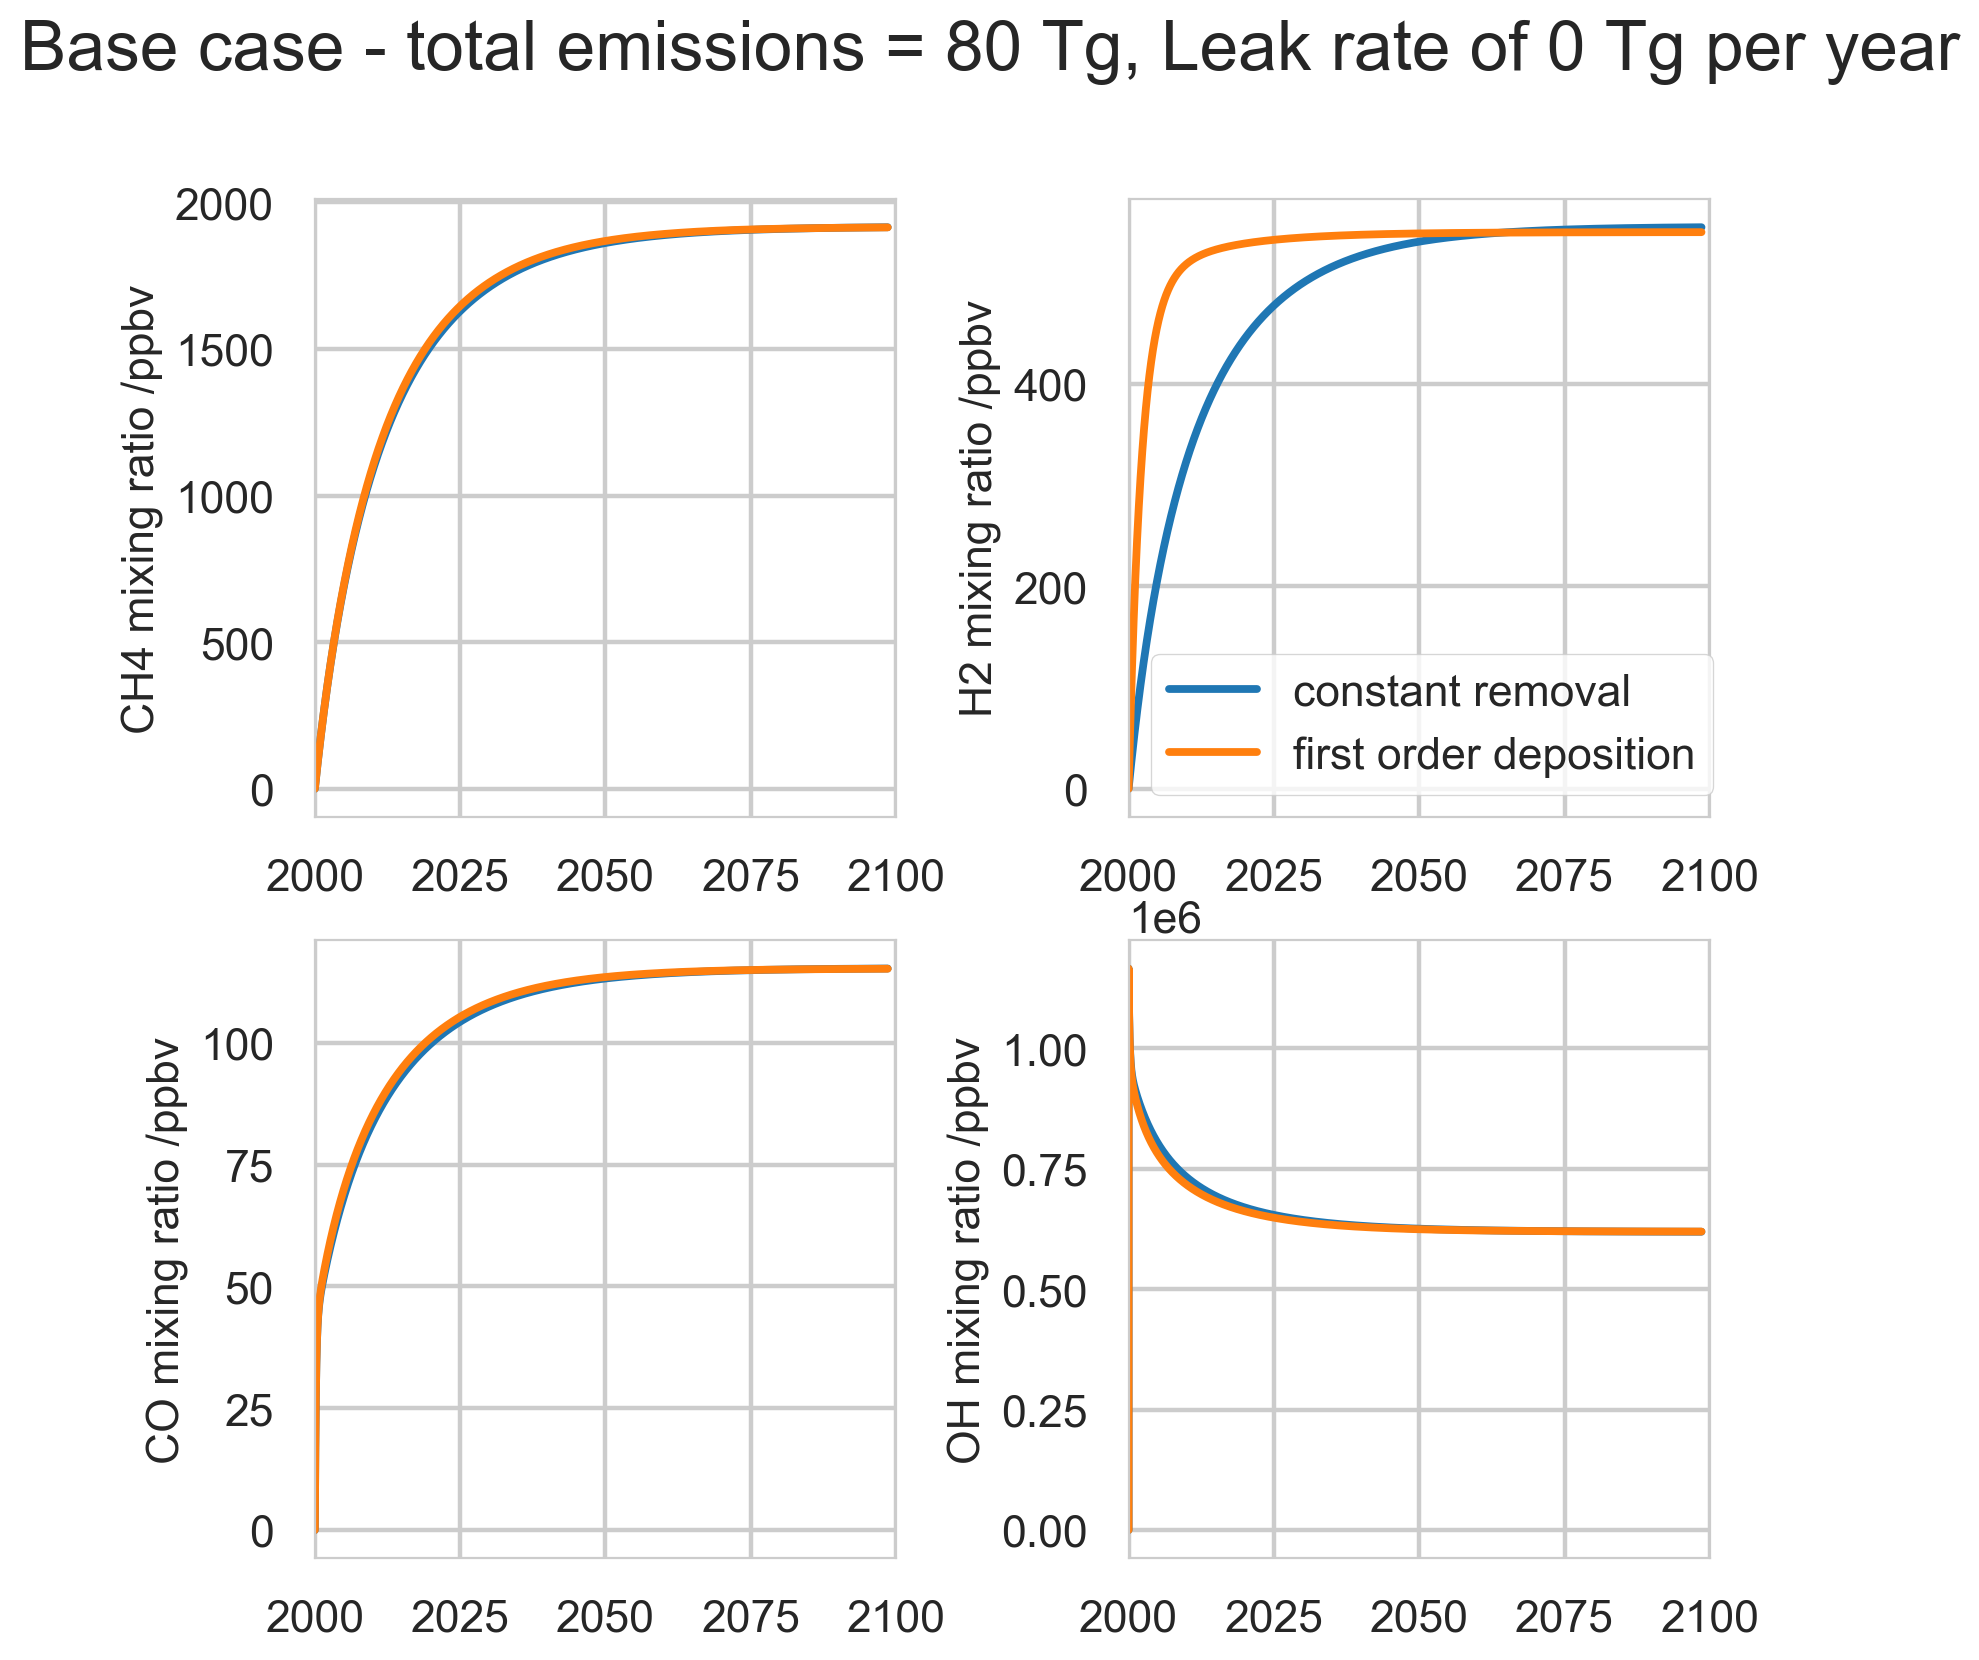

In [15]:
################################
# BASE integration             #
################################
H2base_cr, CH4base_cr, CObase_cr, OHbase_cr    = integrate_box(S=np.array([SH2, SCH4, SCO, SOH]),
                               initial_concs=init,
                               fin= kin_cr, starttime= '1/1/2000' , nyrs=100.)

H2base_dep, CH4base_dep, CObase_dep, OHbase_dep    = integrate_box(S=np.array([SH2, SCH4,SCO, SOH]),
                               initial_concs=init,
                               fin= kin, starttime= '1/1/2000' ,    nyrs=100.)


dStart = datetime.datetime(2000,1,1) # 1 May
dEnd = datetime.datetime(2100,1,1) # 1 July
xticks = pd.date_range(start=dStart, end=dEnd, freq='20Y')

############
# figure 1 #
############
plt.figure(figsize=(9,9), dpi=200.)
plt.subplot(2,2,1)
ax = CH4base_cr.plot()
ax = CH4base_dep.plot()

plt.ylabel('CH4 mixing ratio /ppbv', fontsize=16.)
ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2100-01-01'))

plt.subplot(2,2,2)
ax = H2base_cr.plot(label='constant removal')
ax = H2base_dep.plot(label='first order deposition')
plt.legend()

plt.ylabel('H2 mixing ratio /ppbv', fontsize=16.)
ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2100-01-01'))

plt.subplot(2,2,3)
ax = CObase_cr.plot()
ax = CObase_dep.plot()

plt.ylabel('CO mixing ratio /ppbv', fontsize=16.)
ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2100-01-01'))

plt.subplot(2,2,4)
ax = OHbase_cr.plot()
ax = OHbase_dep.plot()

plt.ylabel('OH mixing ratio /ppbv', fontsize=16.)
ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2100-01-01'))
plt.suptitle('Base case - total emissions = 80 Tg, Leak rate of 0 Tg per year', fontsize=25)
plt.savefig('Figure_1_BASE_leak_rate_zero.png')

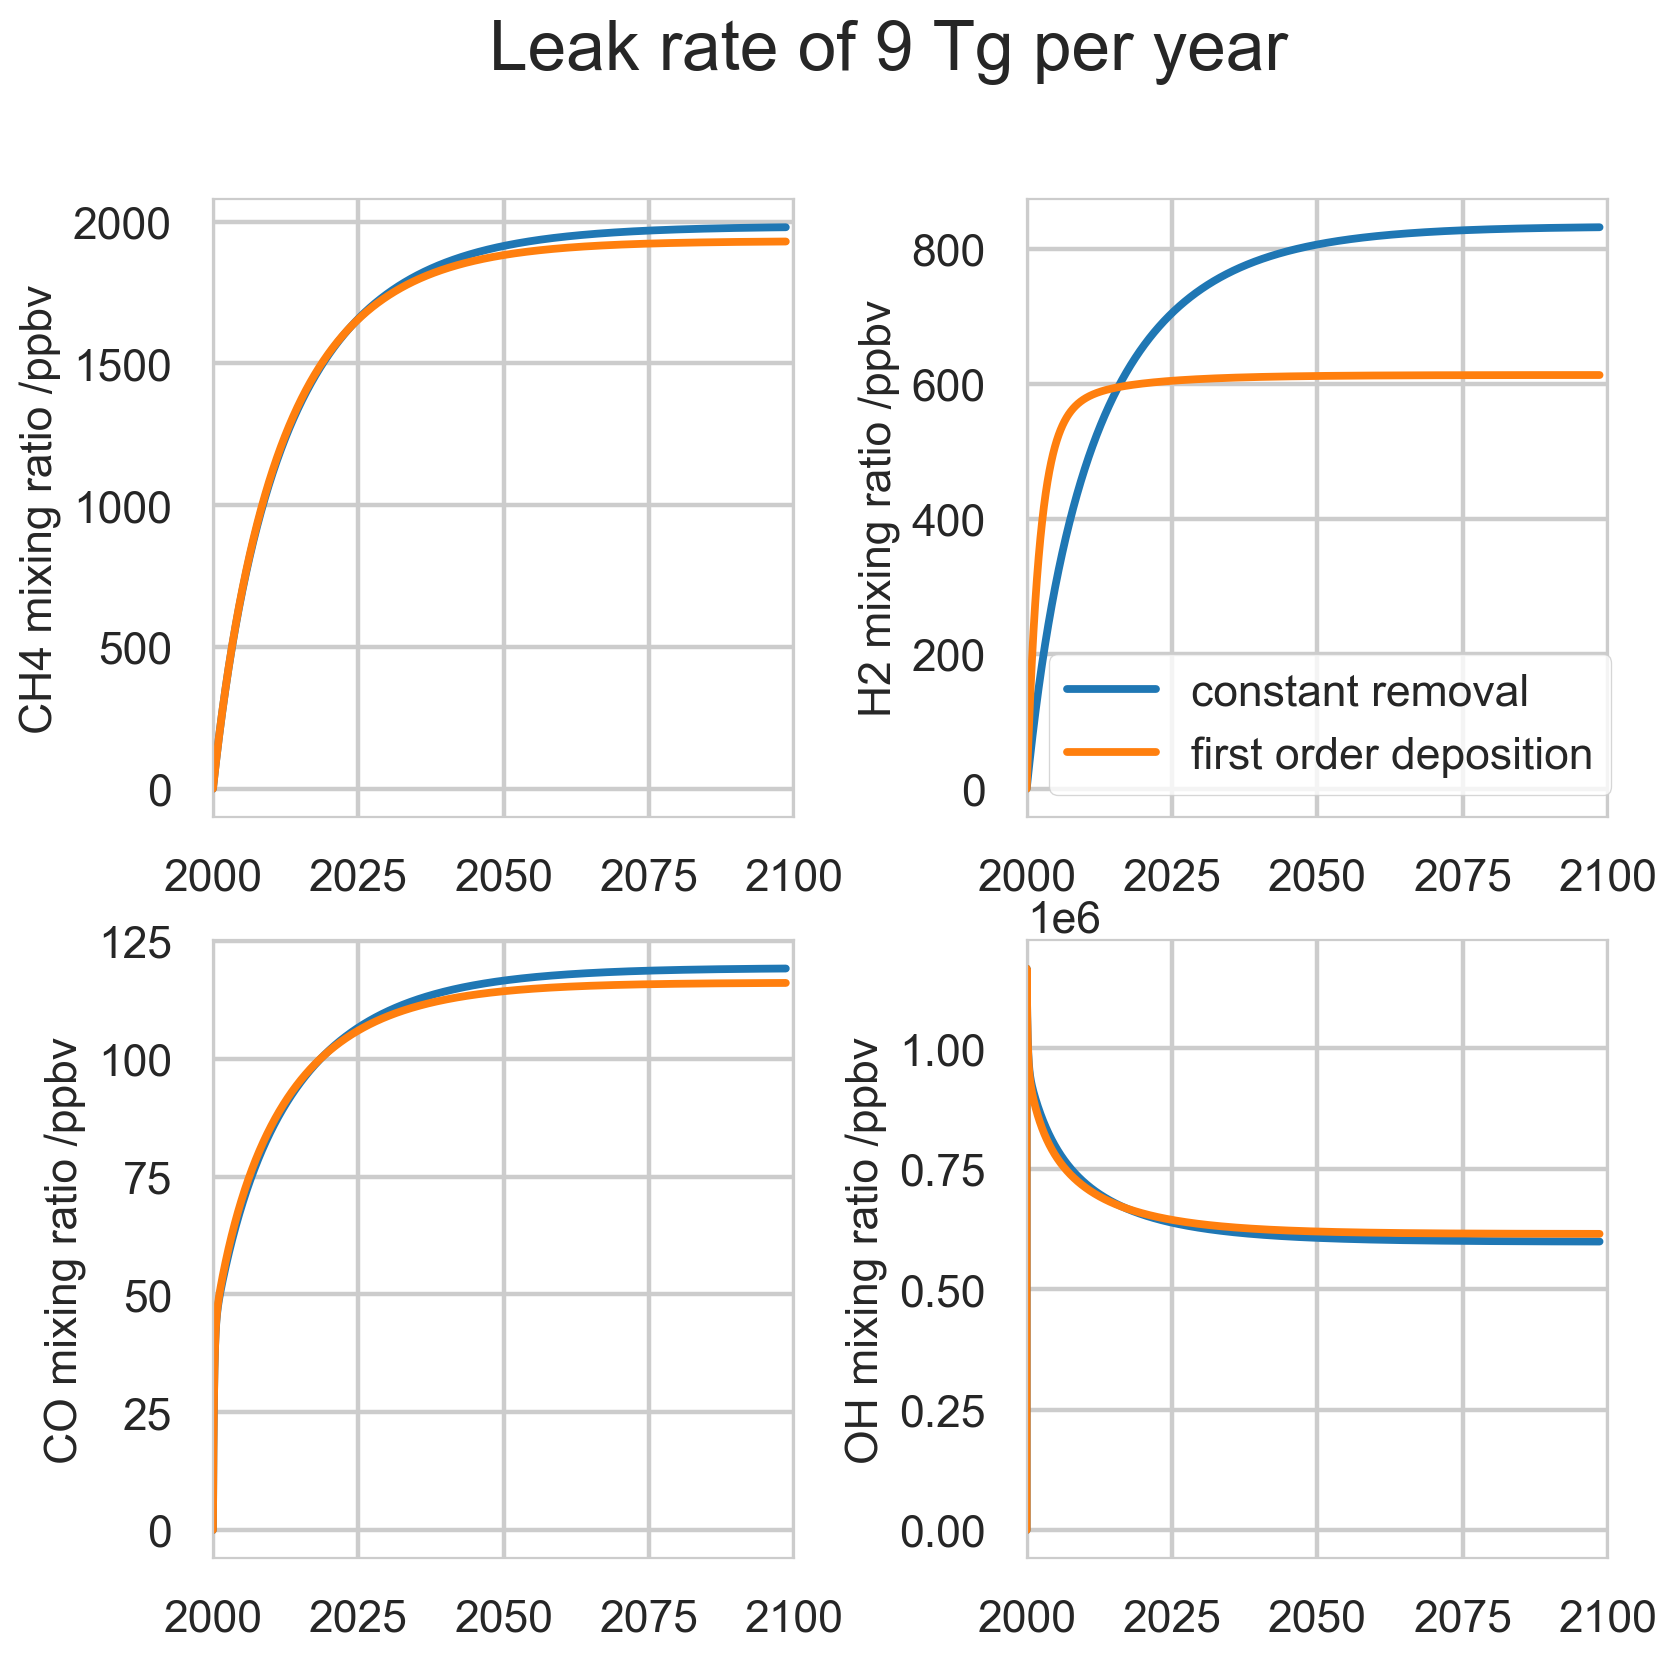

In [16]:
####################################################
# scenario 1 - additional leakage of 9 Tg per year #
####################################################

H2a, CH4a, COa, OHa    = integrate_box(S=np.array([SH2+9, SCH4, SCO, SOH]),
                               initial_concs=init,
                               fin= kin_cr, starttime= '1/1/2000' , nyrs=100.)

H2b, CH4b, COb, OHb    = integrate_box(S=np.array([SH2+9, SCH4,SCO, SOH]),
                               initial_concs=init,
                               fin= kin, starttime= '1/1/2000' ,    nyrs=100.)

############
# figure 2 #
############

plt.figure(figsize=(9,9), dpi=200.)
plt.subplot(2,2,1)
ax = CH4a.plot()
ax = CH4b.plot()

plt.ylabel('CH4 mixing ratio /ppbv', fontsize=16.)
ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2100-01-01'))

plt.subplot(2,2,2)
ax = H2a.plot(label='constant removal')
ax = H2b.plot(label='first order deposition')
plt.legend()

plt.ylabel('H2 mixing ratio /ppbv', fontsize=16.)
ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2100-01-01'))

plt.subplot(2,2,3)
ax = COa.plot()
ax = COb.plot()

plt.ylabel('CO mixing ratio /ppbv', fontsize=16.)
ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2100-01-01'))

plt.subplot(2,2,4)
ax = OHa.plot()
ax = OHb.plot()

plt.ylabel('OH mixing ratio /ppbv', fontsize=16.)
ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2100-01-01'))

plt.suptitle('Leak rate of 9 Tg per year', fontsize=25)
plt.savefig('Figure_2_Leak_rate_9_Tg.png')

In [ ]:
####################################################
# scenario 2, 96 Tg leakage additional             #
####################################################

H2c, CH4c, COc, OHc    = integrate_box(S=np.array([SH2+96, SCH4, SCO, SOH]),
                               initial_concs=init,
                               fin= kin_cr, starttime= '1/1/2000' , nyrs=100.)

H2d, CH4d, COd, OHd    = integrate_box(S=np.array([SH2+96, SCH4,SCO, SOH]),
                               initial_concs=init,
                               fin= kin, starttime= '1/1/2000' ,    nyrs=100.)

############
# PLOT     #
# figure 3 #
############

plt.figure(figsize=(9,9), dpi=200.)
plt.subplot(2,2,1)
ax = CH4c.plot()
ax = CH4d.plot()

plt.ylabel('CH4 mixing ratio /ppbv', fontsize=16.)
ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2100-01-01'))

plt.subplot(2,2,2)
ax = H2c.plot(label='constant removal')
ax = H2d.plot(label='first order deposition')
plt.legend()

plt.ylabel('H2 mixing ratio /ppbv', fontsize=16.)
ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2100-01-01'))

plt.subplot(2,2,3)
ax = COc.plot()
ax = COd.plot()

plt.ylabel('CO mixing ratio /ppbv', fontsize=16.)
ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2100-01-01'))

plt.subplot(2,2,4)
ax = OHc.plot()
ax = OHd.plot()

plt.ylabel('OH mixing ratio /ppbv', fontsize=16.)
ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2100-01-01'))
plt.suptitle('Leak rate of 96 Tg per year', fontsize=25)
plt.savefig('Figure_3_Leak_rate_96_Tg.png')